In [3]:
#Importing functions and loading FITS files. Never used the Astropy Gaussian
#I created my own with the phot function.
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling.functional_models import Gaussian2D
import photometry_funcs as pf
import glob as g
import supplemental_functions as sf

images, headers, files = pf.open_fits('../Lab2/Science_images/*.fits')
#index for image files
z=1

In [4]:
#pulling air masses from FITS Headers
airmasses =np.array([])
for i in range(len(headers)):
    airmasses = np.append(airmasses, headers[i]['AIRMASS'])

In [5]:
#Gain from headers, then averaged.
gain = np.array([])
for i in range(len(headers)):
    gain = np.append(gain, headers[i]['GAIN'])
avg_gain = np.mean(gain)

In [6]:
#Read noise from headers and averaged.
read_noise = np.array([])
for i in range(len(headers)):
    read_noise = np.append(read_noise, headers[i]['READNOI'])
avg_read = np.mean(read_noise)

Text(0.5, 1.0, 'Full FOV of GD 277 in the Red Filter')

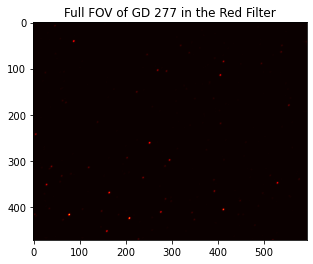

In [47]:
#checking that image is properly loaded.
plt.imshow(images[z], cmap='hot')
plt.title('Full FOV of GD 277 in the Red Filter')
#plt.savefig('../Lab2/Full_FOV_Science_Star_Red_filter.png')

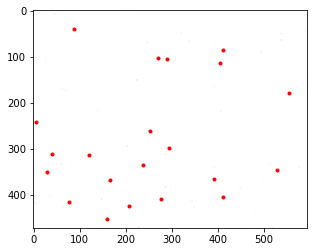

In [9]:
#peaks function call from Yale ASTR 330. 
peaks = sf.findpeaks_maxfilter(images[z],  3000.0)
plt.imshow(images[z], cmap='gray_r')
for i in range(len(peaks)):
    plt.plot(peaks[i,1], peaks[i,0], 'r.')

In [10]:
#displaying peak array for referencing
peaks

array([[ 40,  88],
       [ 85, 412],
       [103, 270],
       [105, 289],
       [114, 405],
       [179, 554],
       [242,   6],
       [261, 252],
       [298, 295],
       [312,  40],
       [314, 120],
       [336, 238],
       [347, 529],
       [351,  29],
       [365, 392],
       [368, 165],
       [405, 412],
       [410, 277],
       [416,  78],
       [424, 208],
       [452, 160]], dtype=int64)

In [11]:
#Centroid function for gaussian provided by Dr. Good.
def centroid_peak(data,peak_x,peak_y,window=10):
    '''
    Given an image and list of peak positions, determine the centroid in the
    region of each peak.
    Parameters
    ----------
    image: array_like
    The image to centroid
    peak_x: int
    x position of a peak
    peak_y: int
    y position of a peak
    window: int, optional
    window within which to calculate the centroid, centered on the peak.
    Default: 10
    Returns
    -------
    centroids: array_like
    x,y ordered centroid associated with the input peak.
    '''
    ndim = data.shape
    boxwidth = int(window/2)
    if (peak_x-boxwidth<=0) or (peak_x+boxwidth>=ndim[1]) or (peak_y-
boxwidth<=0) or (peak_y+boxwidth>=ndim[0]):
        raise AssertionError('Peak too close to edge. Try a smaller window or skip.')
    xx, yy = np.meshgrid(np.arange(peak_x-boxwidth,peak_x+boxwidth),
                         np.arange(peak_y-boxwidth,peak_y+boxwidth))
    image_cutout = data[peak_y-boxwidth:peak_y+boxwidth,peak_x-
boxwidth:peak_x+boxwidth]
    x_center = np.sum(image_cutout * xx) / np.sum(image_cutout)
    y_center = np.sum(image_cutout * yy) / np.sum(image_cutout)
    return peak_x, peak_y, x_center, y_center

In [12]:
pk_x, pk_y, centroid_x,centroid_y = centroid_peak(images[z], 295, 298, window=10)

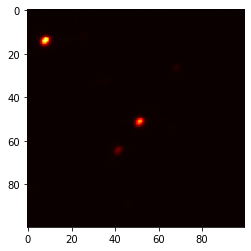

In [13]:
#Making sure I have the right star centered.
plt.imshow(images[z][int(centroid_y)-50:int(centroid_y)+50,int(centroid_x)-50:int(centroid_x)+50], cmap='hot')

In [14]:
#moment function for gaussian.
def find_moment(image,peak_x, peak_y,centroid_x, centroid_y, window=10):
    '''
    image: arr
    fits array
    centroid_x: float
    cetroid of x from centroid_peak function
    centroid_y : float
    same as above
    window: int, optional
    window to find the moment
    default: 10
    Returns
    -------
    sigma_x, sigma_y: array_like
    width of error in x and y.
    '''
    boxwidth = int(window/2)
    xx, yy = np.meshgrid(np.arange(peak_x-boxwidth,peak_x+boxwidth),
                         np.arange(peak_y-boxwidth,peak_y+boxwidth))
    image_cutout = image[peak_y-boxwidth:peak_y+boxwidth,peak_x-
boxwidth:peak_x+boxwidth]
    x_squared = np.sum((xx **2) * image_cutout) / np.sum(image_cutout)
    y_squared = np.sum((yy ** 2) * image_cutout) / np.sum(image_cutout)
    sigma_x = (x_squared - (centroid_x **2)) ** (1.0/2.0)
    sigma_y = (y_squared - (centroid_y **2)) ** (1.0/2.0)
    return sigma_x, sigma_y
sigma_x, sigma_y = find_moment(images[z],pk_x, pk_y, centroid_x, centroid_y, window=10)

In [15]:
#photometry function
def phot(image, pk_x, pk_y, centroid_x, centroid_y, sigma_x, sigma_y, window=10):
    '''image: arr
    fits array
    pk_x:int
    peak x value from peaks array
    pk_y: int
    peak y value as above
    centroid_x: float
    centroid x from function centroid_peak
    centroid_y: float
    centroid y from function centroid_peak
    sigma_x: float
    sigma_x from function find_moment
    sigma_y:float
    sigma_y from function find_moment
    window: int, optional
    window centered on the peak
    Returns
    --------
    model: arr
    normalized gaussian array for a contour map
    psf_convolve: arr
    counts from multiplying cutout and model
    flux:
    sum of the convolution
    '''
    boxwidth = int(window/2)
    xx, yy = np.meshgrid(np.arange(pk_x-boxwidth,pk_x+boxwidth),
                         np.arange(pk_y-boxwidth,pk_y+boxwidth))
    image_cutout = image[pk_y-boxwidth:pk_y+boxwidth,pk_x-
boxwidth:pk_x+boxwidth]
    x_num  = (xx - centroid_x)**2
    y_num  = (yy - centroid_y) **2
    xdenom = 2*(sigma_x**2)
    ydenom = 2*(sigma_y**2)
    gauss = np.exp(-((x_num/xdenom)+(y_num/ydenom)))
    model = gauss/np.sum(gauss)
    psf_convolve = model * image_cutout
    psf_flux = np.sum(psf_convolve)
    return model, psf_convolve, psf_flux, image_cutout, window, gauss
model, psf_convolve, psf_flux, image_cutout, window, gauss = phot(images[z], pk_x, pk_y, centroid_x, centroid_y, sigma_x, sigma_y, window=10)

Text(0.5, 1.0, 'GD-277 Red Filter with 2D Gaussian Contours')

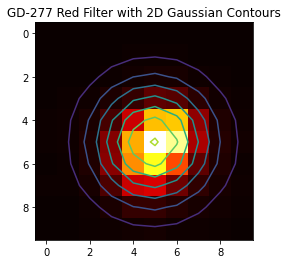

In [16]:
#Science star aperture with Gaussian overlay.
plt.imshow(image_cutout, cmap='hot')
plt.contour(model)
plt.title('GD-277 Red Filter with 2D Gaussian Contours')
#plt.savefig('../Lab2/Science_star_contour.png')

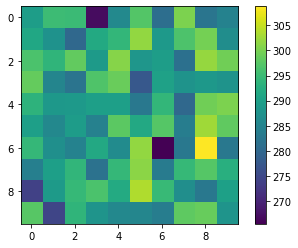

In [17]:
#creating blank sky cutout of each image, windows usually stay in the same portion of sky in each image
#this was purely coincidental that most images had the same area with blank sky.
blank_ap = images[z][150-int(window/2):150+int(window/2),50-int(window/2):50+int(window/2)]
plt.imshow(blank_ap)
plt.colorbar()
blank_convolve = blank_ap * model
blank_convolve_add = np.sum(blank_convolve)
n_sky = np.median(blank_convolve)

pixels = window **2
n_sky_tot = n_sky * pixels
n_star_net = psf_flux - n_sky_tot

In [18]:
#Signal to noise ratio, used to determine arrays for my aperture choice plot.
snr = n_star_net/(np.sqrt(avg_gain*n_star_net + pixels*avg_gain*n_sky+pixels*(avg_read**2)))
snr, psf_flux

(13.421654063326844, 2221.129595339764)

Text(0.5, 1.0, 'Aperture Choosing Plot')

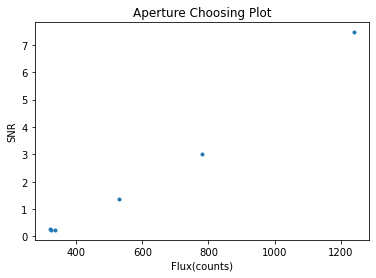

In [19]:
#Creating SNR and flux arrays for aperture choosing plot.
snr_arr = [7.461, 3.014, 1.371, .2371, .2436, .2727]
flux_arr = [1241.02, 779.91, 529.21, 335.33, 322.48, 319.86]
plt.plot(flux_arr, snr_arr,'.')
plt.xlabel('Flux(counts)')
plt.ylabel('SNR')
plt.title('Aperture Choosing Plot')
#plt.savefig('c:/Users/cbhof/Documents/Obsv_Astro/Aperture_Choosing_plot.png')

In [20]:
#using photometry_funcs to get instrument mag and SNR for all stars.
ins_mag = pf.mag_instrument(n_star_net, 30)
print('instrument magnitude:',ins_mag, 'Error (SNR):',snr)

instrument magnitude: -4.601575730343413 Error (SNR): 13.421654063326844


In [46]:
#Science Star arrays
ins_mag_arr = np.array([-3.797, -3.340])
snr_arr_error = np.array([7.424, 5.143])
uncert_snr = 1/snr_arr_error

In [43]:
#standard star arrays as well as least squares calculations in green and infrared.
std_inst_mag = np.array([-6.204, -7.663, -6.439, -1.787, -3.911])
std_inst_mag_green_i = np.array([-6.235, -6.484, -6.182, -3.587, -3.288])
std_real_mag = np.array([13.024, 12.174, 12.936, 13.844, 14.691])
std_real_mag_green_i = np.array([13.074, 12.309, 13.072, 14.941, 15.792])
least_sq_y_green = std_real_mag_green_i - std_inst_mag_green_i
least_sq_x_green = np.array([airmasses[3], airmasses[4], airmasses[6], airmasses[8], airmasses[11]])
least_sq_y = std_real_mag-std_inst_mag
least_sq_x = np.array([airmasses[2], airmasses[5], airmasses[7], airmasses[9], airmasses[10]])

#displaying magnitudes for referencing in report.
print('red filter',least_sq_y)
print()
print('green filter',least_sq_y_green)
print()
print('color', least_sq_y - least_sq_y_green)

red filter [19.228 19.837 19.375 15.631 18.602]

green filter [19.309 18.793 19.254 18.528 19.08 ]

color [-0.081  1.044  0.121 -2.897 -0.478]


a 27.16064480031264 b -5.996972191541053 err a 3.9136521223151095 err b 1.216795353974264 y-err 0.4472135954999579


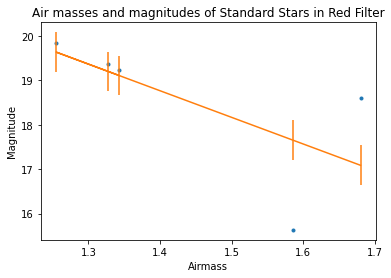

In [45]:
#least squares fitting
#this is all for the red filter, I ran this code combining both filters and replacing all of the original code with
#an _red is fairly tedious, so unless otherwise stated, this code is for the red filter.
delta = 5 * np.sum(least_sq_x **2) - (np.sum(least_sq_x))**2
a_num = (np.sum(least_sq_x ** 2)) * np.sum(least_sq_y) - (np.sum(least_sq_x) * np.sum(least_sq_x * least_sq_y))
b_num = 5 * np.sum(least_sq_x*least_sq_y) - np.sum(least_sq_x) * np.sum(least_sq_y)

a = a_num / delta
b = b_num / delta
uncertainty_y = np.sqrt(1/5-2 * np.sum(least_sq_y-(a+b*least_sq_x))**2)
unc_a = uncertainty_y * np.sqrt(np.sum(least_sq_x)**2 / delta)
unc_b = uncertainty_y * np.sqrt(5/delta)
residual = least_sq_y - (a+b*least_sq_x)
#fitline function
def fitline(x,a,b):
    return a+(b*x)
#plotting with least squares fit.
plt.plot(least_sq_x, least_sq_y, '.')
plt.xlabel('Airmass')
plt.ylabel('Magnitude')
plt.title('Air masses and magnitudes of Standard Stars in Red Filter')
plt.errorbar(least_sq_x, fitline(least_sq_x, a,b), yerr=uncertainty_y)
#plt.savefig('../Lab2/Mag_vs_airmass_stand_red.png')
#used for report. 
print('a', a , 'b', b, 'err a', unc_a, 'err b', unc_b, 'y-err', uncertainty_y)

a 19.937066315627813 b -0.6456963318024311 err a 2.808968832076305 err b 0.8590050950766973 y-err 0.4472135954999579


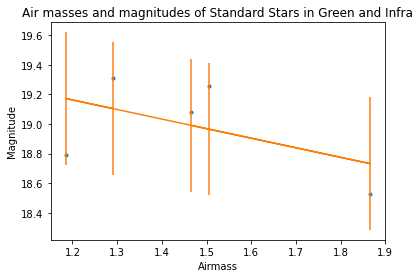

In [44]:
#this is for the green filter and one infrared filter. 
delta_gr = 5 * np.sum(least_sq_x_green **2) - (np.sum(least_sq_x_green))**2
a_num_gr = (np.sum(least_sq_x_green ** 2)) * np.sum(least_sq_y_green) - (np.sum(least_sq_x_green) * np.sum(least_sq_x_green * least_sq_y_green))
b_num_gr = 5 * np.sum(least_sq_x_green*least_sq_y_green) - np.sum(least_sq_x_green) * np.sum(least_sq_y_green)

a_gr = a_num_gr / delta_gr
b_gr = b_num_gr / delta_gr
uncertainty_y_green = np.sqrt(1/5-2 * np.sum(least_sq_y_green-(a_gr+b_gr*least_sq_x_green))**2)
unc_a_green = uncertainty_y_green * np.sqrt(np.sum(least_sq_x_green)**2 / delta_gr)
unc_b_green = uncertainty_y_green * np.sqrt(5/delta_gr)
residual_green = least_sq_y_green - (a+b*least_sq_x_green)

#least square fitting
plt.plot(least_sq_x_green, least_sq_y_green, '.')
plt.xlabel('Airmass')
plt.ylabel('Magnitude')
plt.title('Air masses and magnitudes of Standard Stars in Green and Infra')
plt.errorbar(least_sq_x_green, fitline(least_sq_x_green, a_gr,b_gr), yerr=uncertainty_y_green)
#plt.savefig('../Lab2/Mag_vs_airmass_stand_grinfra.png')
#for report referencing
print("a", a_gr, "b", b_gr, "err a", unc_a_green, "err b", unc_b_green, 'y-err', uncertainty_y_green)

Green and Infrared Chi Squared 0.5312774197618634 Red Chi Squared 10.767901269377212


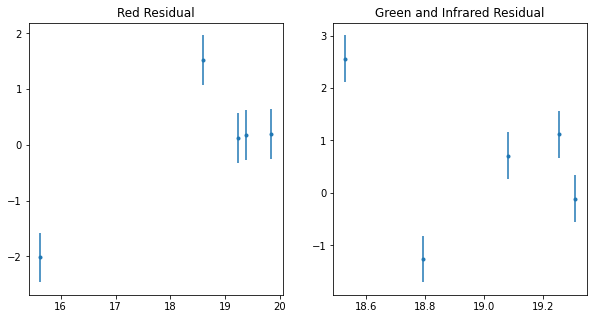

In [25]:
#Chi squared calculations as well as residual fitting to check for patterns.
chi_num_gr = least_sq_y_green - fitline(least_sq_x_green, a_gr, b_gr)
chi_sq_gr = np.sum(chi_num_gr **2 / uncertainty_y_green **2)
chi_num = least_sq_y - fitline(least_sq_x, a, b)
chi_sq = np.sum(chi_num **2 / uncertainty_y **2)
print('Green and Infrared Chi Squared',1/3 * chi_sq_gr,'Red Chi Squared', 1/3 * chi_sq)
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[1].errorbar(least_sq_y_green, residual_green, yerr=uncertainty_y_green, fmt='.')
axs[1].set_title('Green and Infrared Residual')
axs[0].errorbar(least_sq_y, residual, yerr=uncertainty_y, fmt='.')
axs[0].set_title('Red Residual')
plt.show()
#plt.savefig('../Lab2/Red_green_infra_residuals.png')

In [26]:
#calculations of magnitudes as as well as color and error
#used in report. 
green_mag = ins_mag_arr[0]+a+b*headers[0]["AIRMASS"]
red_mag = ins_mag_arr[1]+a+b*headers[1]["AIRMASS"]
print('Red Mag = ', red_mag, 'Green Mag =', green_mag)
print('Red-Green', red_mag - green_mag)
print('Error in magnitudes, Red:', red_mag/snr_arr_error[0], 'Green:', green_mag/snr_arr_error[1])

Red Mag =  11.994615638593682 Green Mag = 11.945409747618474
Red-Green 0.04920589097520889
Error in magnitudes, Red: 1.6156540461467783 Green: 2.3226540438690404
